# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2023-10-27'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Get IQ data

In [4]:
SHOTS = int(1e2)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.1

IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
IQ_data_extreme = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

100%|██████████| 95/95 [00:00<00:00, 2684.91it/s]


# Pickle for other applications

In [16]:
import pickle

with open('IQ_data.pkl', 'wb') as f:
    pickle.dump(IQ_data, f)

with open('IQ_data_extreme.pkl', 'wb') as f:
    pickle.dump(IQ_data_extreme, f)

with open('qubit_mapping.pkl', 'wb') as f:
    pickle.dump(simulator.qubit_mapping, f)

with open('stim_circ.pkl', 'wb') as f:
    pickle.dump(simulator.stim_circ, f)

# Simulator

# Decode IQ data

In [17]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [1]:
import cpp_soft_info
from Scratch import load_calibration_memory

bandwiths = [2]*127
all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=OTHER_DATE)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwiths)

NameError: name 'provider' is not defined

# Using cpp kde

In [ ]:
_DETAILED = True



matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                            p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

matching = pymatching.Matching.from_detector_error_model(model)
result_extreme = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

print("num_errors IQ:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors IQ EXTREME:", result_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors IQ: 0 out of 100 shots for _RESETS = True
num_errors IQ EXTREME: 1 out of 100 shots for _RESETS = True


In [ ]:
result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, 
                                         simulator.qubit_mapping, kde_dict, _DETAILED)

result_extreme_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data_extreme, ROUNDS, int(LOGICAL), _RESETS,
                                            simulator.qubit_mapping, kde_dict, _DETAILED)

print("num_errors KDE:", result_kde.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors KDE EXTREME:", result_extreme_kde.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors KDE: 1 out of 100 shots for _RESETS = True
num_errors KDE EXTREME: 5 out of 100 shots for _RESETS = True


In [ ]:
p_meas = -1
p_meas = 7e-2 

matching = pymatching.Matching.from_detector_error_model(model)
result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

matching = pymatching.Matching.from_detector_error_model(model)
result_informed_extreme = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, IQ_data_extreme[:],
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                             p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

print("num_errors informed:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors informed EXTREME:", result_informed_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors informed: 1 out of 100 shots for _RESETS = True
num_errors informed EXTREME: 2 out of 100 shots for _RESETS = True


In [ ]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED)

matching = pymatching.Matching.from_detector_error_model(model)
result_flat_extreme = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, IQ_data_extreme,
                                                         ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                                            simulator.processed_scaler_dict, _detailed=_DETAILED)

print("num_errors:", result_flat.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors EXTREME:", result_flat_extreme.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", _RESETS)

num_errors: 2 out of 100 shots for _RESETS = True
num_errors EXTREME: 5 out of 100 shots for _RESETS = True


# Plot the results

In [ ]:
print("\nIQ:", result.indices, "\nkde:", sorted(result_kde.indices), "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)
print("\nIQ EXTREME:", result_extreme.indices, "\nkde EXTREME:", sorted(result_extreme_kde.indices), "\nFlat EXTREME:", result_flat_extreme.indices, "\nInformed EXTREME", result_informed_extreme.indices)


IQ: [] 
kde: [65] 
Flat: [65, 84] 
Informed [65]

IQ EXTREME: [66] 
kde EXTREME: [41, 65, 66, 70, 85] 
Flat EXTREME: [12, 65, 66, 70, 84] 
Informed EXTREME [66, 70]


-----IQ False decoding -----


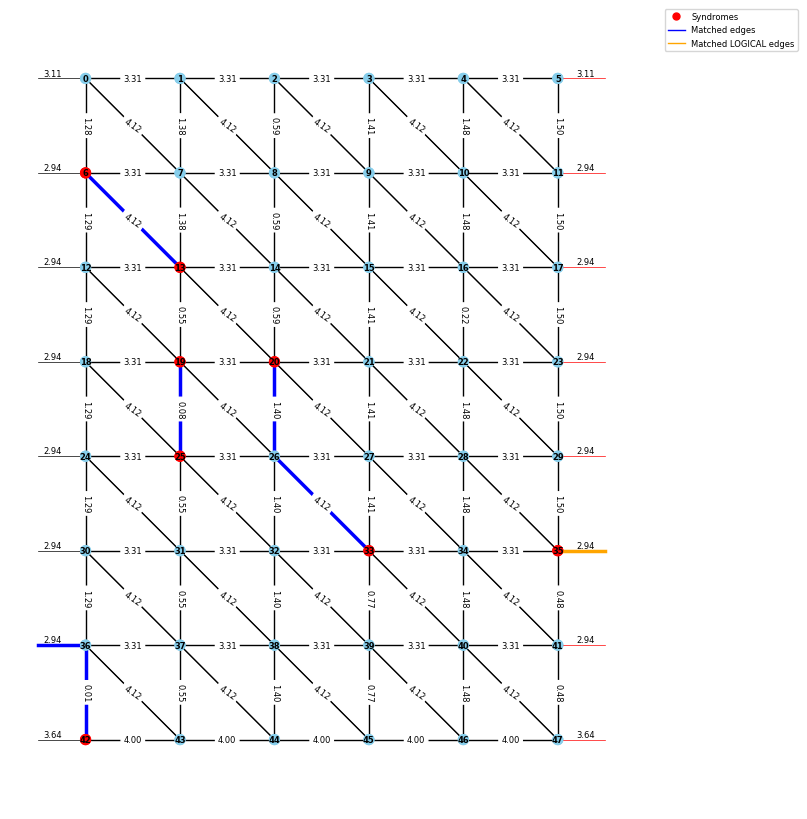

-----flat True decoding-----


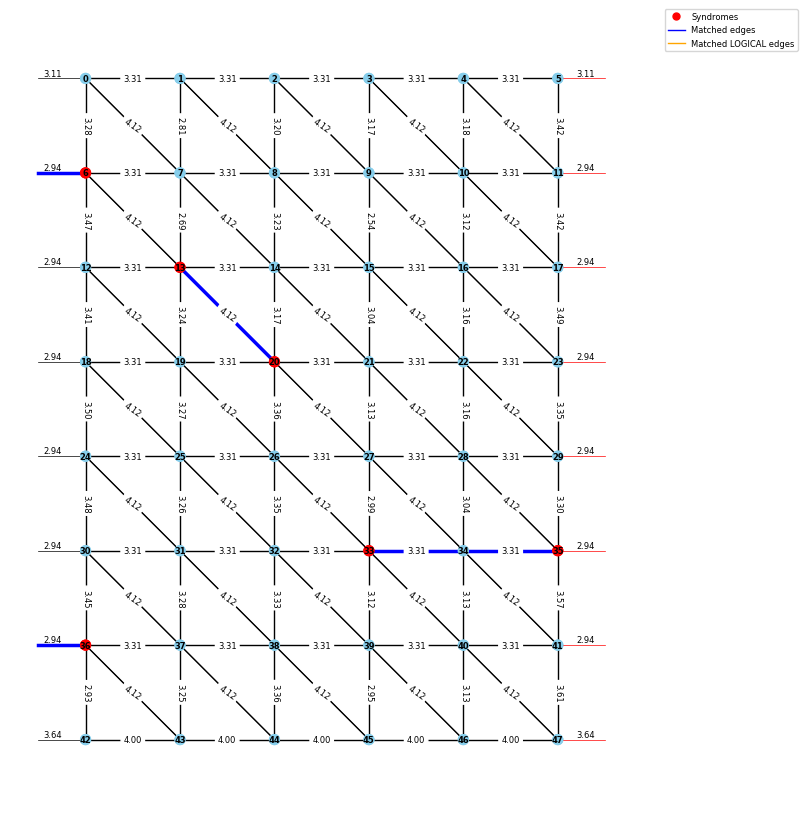

-----INFORMED False decoding-----


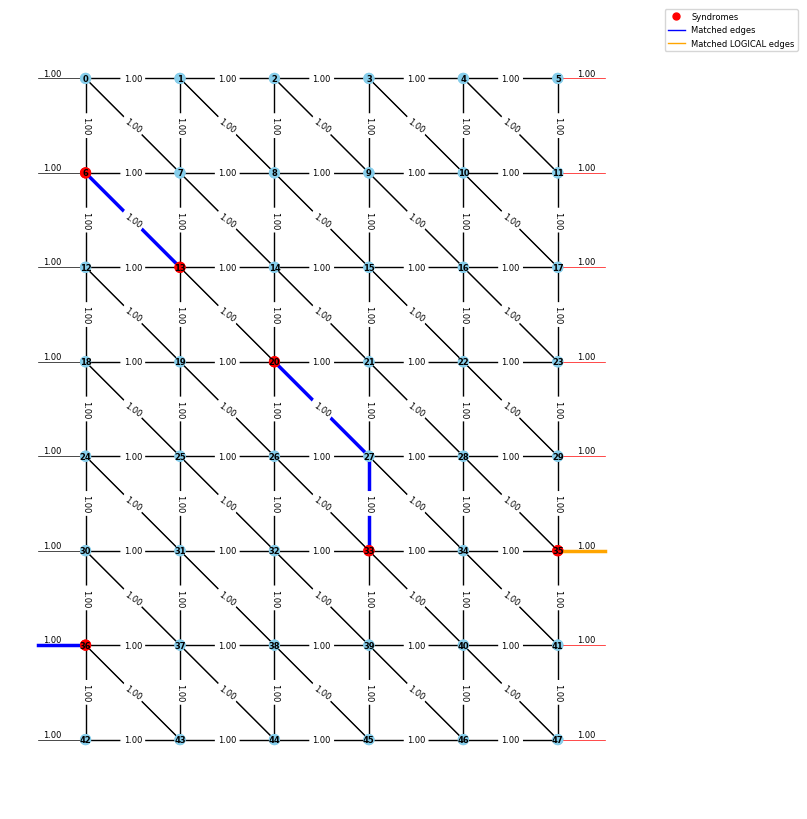

In [34]:
from soft_info import draw_matching_graph


index = 65

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result_extreme_kde
details = to_be_result.error_details[index]
print(f"-----IQ {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----flat {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print(f"-----INFORMED {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [14]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

indices that are in informed but not in IQ with len: 1
[65]
indices that are in IQ but not in informed with len: 0
[]

indices that are in IQ but not in flat with len: 0
[]
indices that are in flat but not in IQ with len: 2
[65, 84]


# Analyse specific shots

{'0111000 100100 110000 101000 101000 000000 000000 000000': 1}


100%|██████████| 133/133 [00:00<00:00, 2043378.87it/s]

mean time edge weight: 2.795152916630156

[(0, -1), (33, 27), (21, 14), (21, 20), (24, 31), (37, 38), (37, 36), (43, 44), (43, 42), (34, 35), (41, 47)]
-----IQ-----


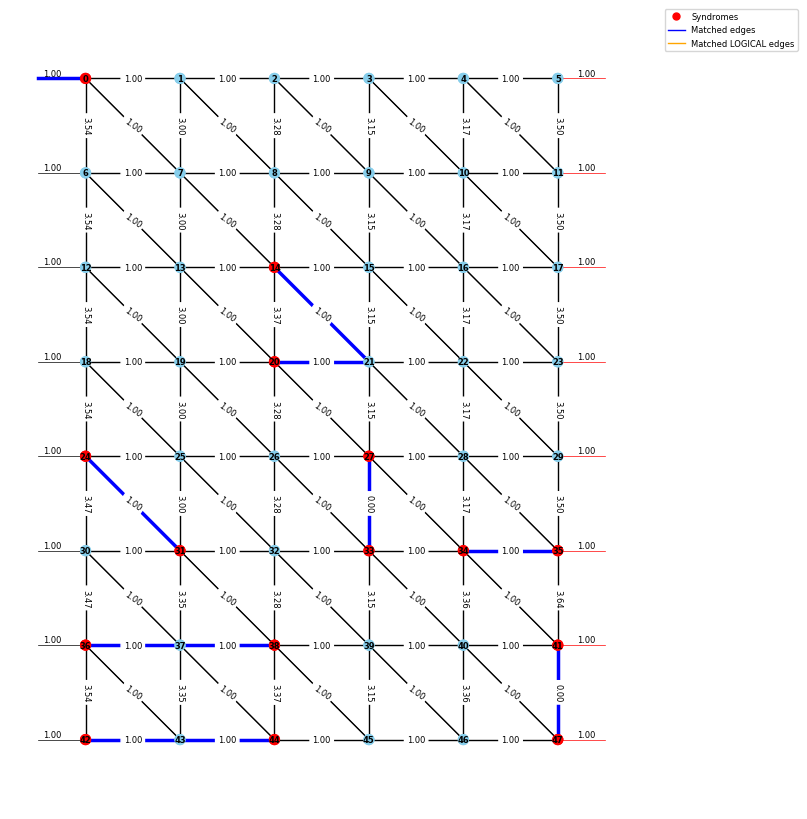

In [15]:
from tqdm import tqdm

index = 83
IQ_data_new = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print(cpp_soft_info.get_counts(IQ_data_new, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print()
print(details.matched_edges)

print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)